In [1]:
# data : https://www.kaggle.com/ashydv/customer-clustering-k-means-clustering/data

In [2]:
# Customer Segmentation with RFM and K-Means

#### Objectives:
Segment a Customer Database and tag the groups with RFM

#### Data:
Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

#### Approach:
Create segments with K-Means and use RFM for Explainability

In [49]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

#Importing Libraries
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# scipy
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan


In [4]:
retail = pd.read_csv("./data/OnlineRetail.csv", sep = ',',encoding = "ISO-8859-1", header= 0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [5]:
retail.shape

(541909, 8)

In [6]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
# Data Cleaning
# parse date and generate datetime column
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = "%d-%m-%Y %H:%M")
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
# Let's look top 5 rows to perform a quality check
retail.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [10]:
#Do we have Nan?
retail.isnull().values.any()

True

In [11]:
# How Many and where?
retail.isnull().sum()*100/retail.shape[0]

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [12]:
# Dropping Nans
retail = retail.dropna()

In [13]:
retail.isnull().sum()*100/retail.shape[0]

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

**RFM**

In [14]:
### Extracting R (Recency), F (Frequency), M (Monetary) columns form the data.

In [15]:
#RFM implementation

# Extracting amount by multiplying quantity and unit price and saving the data into amount variable.
retail["Amount"]  = retail.Quantity * retail.UnitPrice

**Monetary Value**

In [16]:
# Monetary Function

# Finding total amount spent per customer
monetary = retail.groupby("CustomerID").Amount.sum()
monetary = monetary.reset_index()
monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


**Frequency Value**

In [17]:
#Frequency function

# Getting the count of orders made by each customer based on customer ID.
frequency = retail.groupby("CustomerID").InvoiceNo.count()
frequency = frequency.reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


**Merging Amount and Frequency columns**

In [18]:
#creating master dataset
master = monetary.merge(frequency, on = "CustomerID", how = "inner")
master.head()

,CustomerID,Amount,InvoiceNo
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


**Recency Value**

In [19]:
# Finding max data
maximum = max(retail.InvoiceDate)

In [20]:
# Adding one more day to the max data, so that the max date will have 1 as the difference and not zero.
maximum = maximum + pd.DateOffset(days = 1)

In [21]:
retail['diff'] = maximum - retail.InvoiceDate
retail.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,374 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,374 days 04:24:00


In [22]:
#Dataframe merging by recency
recency = retail.groupby('CustomerID')['diff'].min()
recency = recency.reset_index()
recency.head()

,CustomerID,diff
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


**RFM combined Final DataFrame**

In [23]:
#Combining all recency, frequency and monetary parameters
RFM = master.merge(recency, on = "CustomerID")
RFM.columns = ['CustomerID','Amount','Frequency','Recency']
RFM.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,326 days 02:33:00
1,12347.0,4310.00,182,2 days 20:58:00
2,12348.0,1797.24,31,75 days 23:37:00
3,12349.0,1757.55,73,19 days 02:59:00
4,12350.0,334.40,17,310 days 20:49:00


In [24]:
RFM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   CustomerID  4372 non-null   float64        
 1   Amount      4372 non-null   float64        
 2   Frequency   4372 non-null   int64          
 3   Recency     4372 non-null   timedelta64[ns]
dtypes: float64(2), int64(1), timedelta64[ns](1)
memory usage: 136.8 KB


**Outlier Treatment**

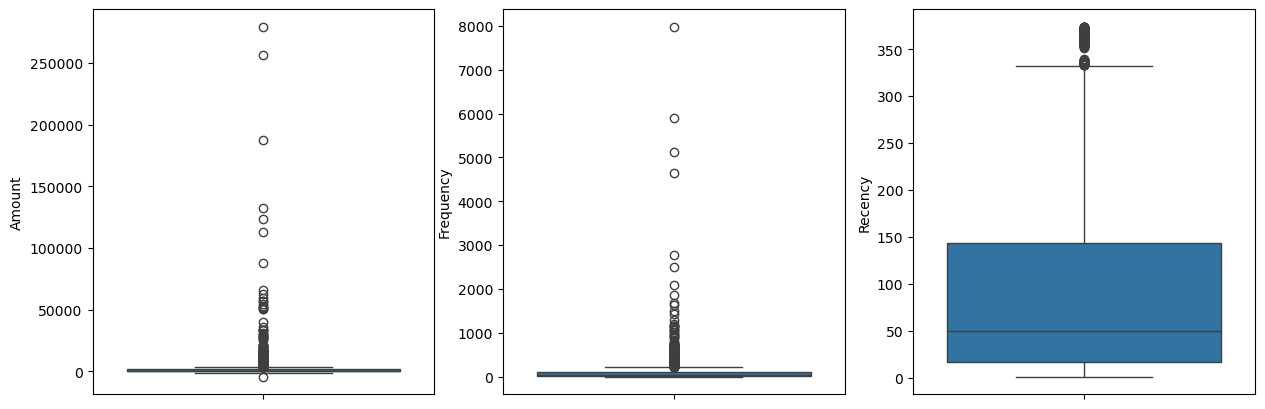

In [25]:
# outlier treatment for Amount
# We treat outliers as they distort the RFM groups, let's analyze which outliers we have
fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.boxplot(RFM.Amount, ax = axs[0])
sns.boxplot(RFM.Frequency, ax = axs[1])
sns.boxplot(RFM.Recency.dt.days, ax = axs[2])

plt.tight_layout
plt.show()

In [26]:
# outlier treatment for Amount
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

In [27]:
# outlier treatment for Frequency
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

In [28]:
# outlier treatment for Recency
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

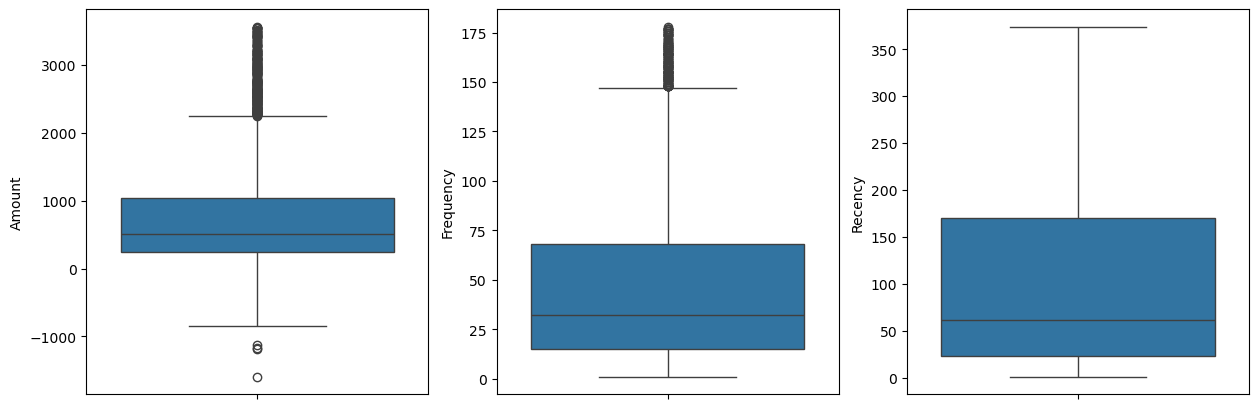

In [29]:
fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.boxplot(RFM.Amount, ax = axs[0])
sns.boxplot(RFM.Frequency, ax = axs[1])
sns.boxplot(RFM.Recency.dt.days, ax = axs[2])

plt.tight_layout
plt.show()

**We can see that most of the naughty outliers have been removed**

In [48]:
RFM.head(3)

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,326 days 02:33:00
1,12348.0,1797.24,31,75 days 23:37:00
2,12349.0,1757.55,73,19 days 02:59:00


**Scaling the RFM data**

In [45]:
# In clustering exercises scaling the data may be a good way to improve the quality of the comparisons between points, 
# this reduces the impact of large dimensions
# standardise all parameters
RFM_norm1 = RFM.drop("CustomerID", axis=1)
RFM_norm1.Recency = RFM_norm1.Recency.dt.days

standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

In [32]:
RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['Frequency','Amount','Recency']
RFM_norm1.head()

,Frequency,Amount,Recency
0,-1.041614,-1.070949,2.136422
1,1.385298,-0.375498,-0.282050
2,1.331702,0.631707,-0.821629
3,-0.590055,-0.711233,1.982257
4,1.045238,1.159290,-0.657828


**Hopkins Statistics:**
The Hopkins statistic, is a statistic to evaluate the cluster tendency,(how well the data can be clustered)

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.
- If the value is around 0.5, it is random.
- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [33]:

def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [34]:
hopkins(RFM_norm1)

0.8982474159369667

**K-Means**

**Silhouette Analysis**

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$
$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of
$q$ is the mean intra-cluster distance to all the points in its own cluster.
* The value of the silhouette score range lies between -1 to 1. 
* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 
* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [35]:
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])

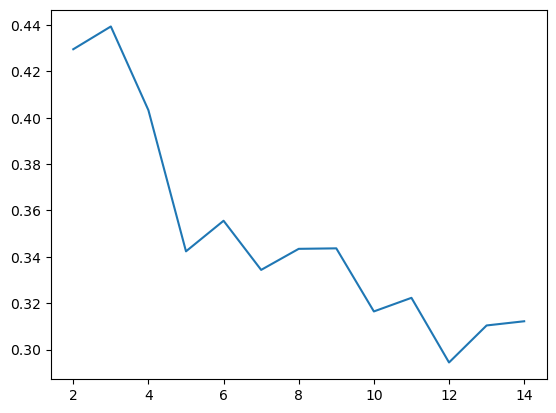

In [36]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

**Sum of Squared Distances**

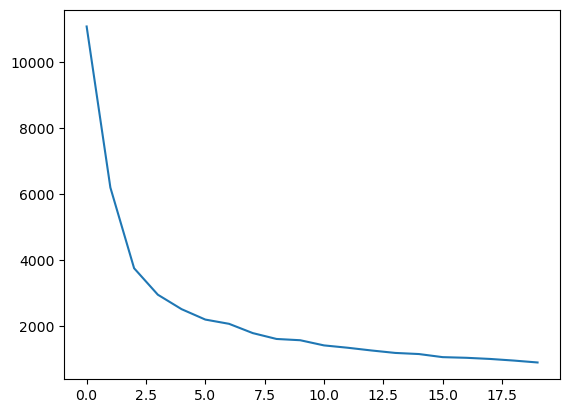

In [50]:
# sum of squared distances and apply elbow method
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=100)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [38]:
# Kmeans with K=5
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(RFM_norm1)

KMeans(max_iter=50, n_clusters=5)

In [39]:
# analysis of clusters formed
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency', 'ClusterID']
RFM_km.head()

,CustomerID,Amount,Frequency,Recency,ClusterID
0,12346.0,0.00,2,326 days 02:33:00,2
1,12348.0,1797.24,31,75 days 23:37:00,0
2,12349.0,1757.55,73,19 days 02:59:00,0
3,12350.0,334.40,17,310 days 20:49:00,2
4,12352.0,1545.41,95,36 days 22:13:00,1


In [40]:
RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_amount = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [41]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,1201.448994,53.668613,50.119708
1,1,912.557139,114.021798,53.980926
2,2,327.037096,20.558856,262.393839
3,3,2471.402482,117.888283,38.198910
4,4,357.594530,23.325785,57.572681


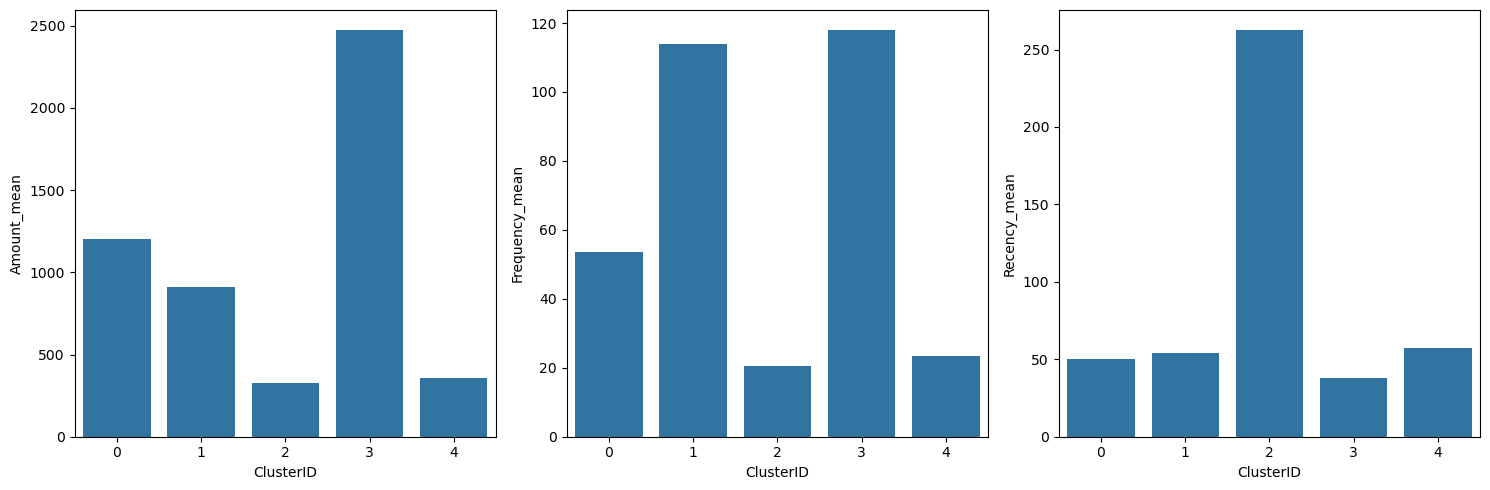

In [42]:
fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.barplot(x=df.ClusterID, y=df.Amount_mean, ax = axs[0])
sns.barplot(x=df.ClusterID, y=df.Frequency_mean, ax = axs[1])
sns.barplot(x=df.ClusterID, y=df.Recency_mean, ax = axs[2])
plt.tight_layout()            
plt.show()

**Conclusions**
1. On RFM analysis it was found that Customers with Cluster ID 4 are the best and loyal customers.
2. Cluster Id 3 are customers who are not interested in retail store.
3. People with cluster ID 0,1,2 needs targeted marketing marketing based on their demographics, buying pattern etc. 

In [43]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.8.4
numpy               1.26.4
pandas              2.2.2
scipy               1.13.0
seaborn             0.13.2
session_info        1.0.0
sklearn             1.4.2
-----
IPython             8.22.2
jupyter_client      8.6.1
jupyter_core        5.7.2
-----
Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:16:53) [MSC v.1929 64 bit (AMD64)]
Windows-10-10.0.22631-SP0
-----
Session information updated at 2024-05-31 15:56
